# Medical Data Manipulation and Preprocessing

## Introduction
Medical imaging plays a crucial role in diagnosing and treating various conditions. Magnetic Resonance Imaging (MRI) is one of the most commonly used modalities, providing detailed images of soft tissues. However, raw MRI scans often require preprocessing to improve analysis and model performance in machine learning applications.

In this notebook, we explore preprocessing techniques for 3D MRI scans using the BraTS2021 dataset (Brain Tumor Segmentation 2021). The dataset contains multimodal MRI scans, including:

T1-weighted MRI (T1) – Standard anatomical reference.

T1 contrast-enhanced (T1ce) – Highlights blood vessels and lesions.

T2-weighted MRI (T2) – Captures fluid content differences.

FLAIR (Fluid-Attenuated Inversion Recovery) – Suppresses cerebrospinal fluid for better lesion visibility.

Segmentation Masks – Ground truth labels indicating tumor regions.

Preprocessing these images ensures consistency, reduces artifacts, and improves the generalization of deep learning models.


## Objectives
In this project, we will:
✅ Load and extract 3D MRI scans from .tar archives.
✅ Preprocess and normalize images for consistency.
✅ Visualize different slices of the MRI scans.
✅ Apply data augmentation to enhance dataset variability.
✅ Implement a PyTorch DataLoader for efficient image handling.

# 1️⃣ Loading the BraTS2021 Dataset
MRI scans in BraTS2021 are stored in NIfTI format (.nii.gz), which supports 3D volumetric data. We first extract the dataset and load the required modalities.

In [37]:
# Import necessary libraries
import os
import tarfile
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# Install TorchIO if not already installed
!pip install torchio  
import torchio as tio

import pandas as pd  # Data processing, CSV file I/O

# List available dataset files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brats-2021-task1/BraTS2021_00495.tar
/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
/kaggle/input/brats-2021-task1/BraTS2021_00621.tar


In [38]:
# Define dataset path
dataset_path = "/kaggle/input/brats-2021-task1/BraTS2021_00495.tar"

# Extract files
with tarfile.open(dataset_path, "r") as tar:
    tar.extractall(path="/kaggle/working/")

# 2️⃣ Loading and Visualizing the MRI Scans
MRI scans are 3D volumes with shape (H, W, D), where:

H = Height

W = Width

D = Depth (number of slices)
# Loading NIfTI Files

In [39]:
# Load a NIfTI file using nibabel
def load_nii(file_path):
    return nib.load(file_path).get_fdata()

# Define paths for different modalities
base_path = "/kaggle/working/BraTS2021_00495/"
t1_path = os.path.join(base_path, "BraTS2021_00495_t1.nii.gz")
t1ce_path = os.path.join(base_path, "BraTS2021_00495_t1ce.nii.gz")
t2_path = os.path.join(base_path, "BraTS2021_00495_t2.nii.gz")
flair_path = os.path.join(base_path, "BraTS2021_00495_flair.nii.gz")
seg_path = os.path.join(base_path, "BraTS2021_00495_seg.nii.gz")

# Load images
t1 = load_nii(t1_path)
t1ce = load_nii(t1ce_path)
t2 = load_nii(t2_path)
flair = load_nii(flair_path)
seg = load_nii(seg_path)

# Print shape
print("T1 shape:", t1.shape)
print("T1ce shape:", t1ce.shape)
print("T2 shape:", t2.shape)
print("Flair shape:", flair.shape)
print("Segmentation Mask shape:", seg.shape)


T1 shape: (240, 240, 155)
T1ce shape: (240, 240, 155)
T2 shape: (240, 240, 155)
Flair shape: (240, 240, 155)
Segmentation Mask shape: (240, 240, 155)


In [40]:
# Load the MRI 3D Scan Image
def extract_tarfile(tar_path, extract_path):
    """Extracts a .tar archive"""
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path=extract_path)

def load_nifti_image(file_path):
    """Loads a .nii.gz file and returns a NumPy array"""
    nifti_img = nib.load(file_path)
    return nifti_img.get_fdata()

In [41]:
# Define dataset paths
tar_path = '/kaggle/input/brats-2021-task1/BraTS2021_00495.tar'  
extract_path = './BraTS2021_00495/'
extract_tarfile(tar_path, extract_path)

In [42]:
# Load MRI modalities and segmentation mask
t1_path = os.path.join(extract_path, 'BraTS2021_00495_t1.nii.gz')
t1ce_path = os.path.join(extract_path, 'BraTS2021_00495_t1ce.nii.gz')
t2_path = os.path.join(extract_path, 'BraTS2021_00495_t2.nii.gz')
flair_path = os.path.join(extract_path, 'BraTS2021_00495_flair.nii.gz')
seg_path = os.path.join(extract_path, 'BraTS2021_00495_seg.nii.gz')

In [43]:
# Convert to NumPy arrays
t1 = load_nifti_image(t1_path)
t1ce = load_nifti_image(t1ce_path)
t2 = load_nifti_image(t2_path)
flair = load_nifti_image(flair_path)
seg = load_nifti_image(seg_path)

In [44]:
# Print shapes
print(f"T1 shape: {t1.shape}")
print(f"T1ce shape: {t1ce.shape}")
print(f"T2 shape: {t2.shape}")
print(f"Flair shape: {flair.shape}")
print(f"Segmentation Mask shape: {seg.shape}")

T1 shape: (240, 240, 155)
T1ce shape: (240, 240, 155)
T2 shape: (240, 240, 155)
Flair shape: (240, 240, 155)
Segmentation Mask shape: (240, 240, 155)


# 3️⃣ Visualizing Slices
MRI scans are 3D; thus, we visualize a middle slice from each modality.

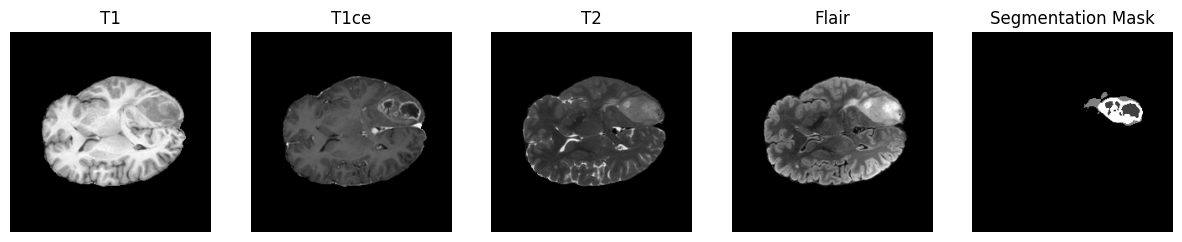

In [45]:
def plot_middle_slices(modalities, titles):
    """Plot middle slices of given MRI modalities"""
    fig, axes = plt.subplots(1, len(modalities), figsize=(15, 5))
    mid_slice = modalities[0].shape[2] // 2
    
    for i, (modality, title) in enumerate(zip(modalities, titles)):
        axes[i].imshow(modality[:, :, mid_slice], cmap='gray')
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.show()

plot_middle_slices([t1, t1ce, t2, flair, seg], ['T1', 'T1ce', 'T2', 'Flair', 'Segmentation Mask'])

# 4️⃣ Data Augmentation
Why augment MRI scans?

Increases dataset diversity.

Helps models generalize better.

Compensates for limited medical datasets.

We apply TorchIO transformations:
✅ Flip MRI scan across different axes.
✅ Crop to focus on the brain region.
✅ Resample to uniform voxel sizes.
✅ Apply elastic and affine transformations for structural variation.

Applying Transformations

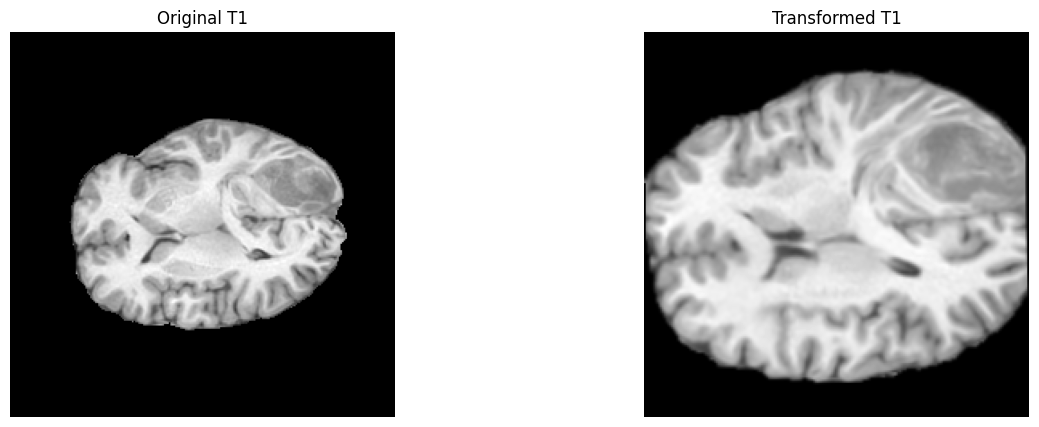

In [46]:
transform = tio.Compose([
    tio.RandomFlip(axes=(0,), p=1),  # Flip anteroposterior axis
    tio.RandomFlip(axes=(1,), p=0.5),  # Flip lateral axis with 50% probability
    tio.CropOrPad((160, 160, 100)),  # Center Crop
    tio.Resample(0.75),  # Resample to 0.75mm isotropic resolution
    tio.OneOf({
        tio.RandomElasticDeformation(): 0.6,
        tio.RandomAffine(): 0.4
    }),
    tio.RandomBlur(p=0.6),
    tio.RandomNoise(p=0.6)
])
""" Apply transformations
t1_transformed = transform(tio.ScalarImage(t1_path))

# Display transformed image slice
plot_middle_slices([t1, t1_transformed.numpy()], ['Original T1', 'Transformed T1'])
"""
# Convert transformed tensor back to NumPy and remove extra dimension
t1_transformed_np = t1_transformed.numpy().squeeze()  # Removes extra dim

# Plot middle slices
plot_middle_slices([t1, t1_transformed_np], ['Original T1', 'Transformed T1'])


# 5️⃣ Implementing a PyTorch DataLoader
Efficient loading is critical when training deep learning models on 3D medical images.

In [47]:
class BraTSDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        img = nib.load(img_path).get_fdata()
        img = np.expand_dims(img, axis=0)  # Add channel dimension
        img = torch.tensor(img, dtype=torch.float32)
        
        if self.transform:
            img = self.transform(img)
        
        return img

In [48]:
# Define dataset and DataLoader
dataset = BraTSDataset([t1_path, t1ce_path, t2_path, flair_path, seg_path], transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Display batch information
batch = next(iter(dataloader))
print(f"Batch shape: {batch.shape}")

Batch shape: torch.Size([2, 1, 214, 214, 134])


In [49]:
# Load a sample MRI scan (T1, T1ce, T2, Flair, Segmentation)
def load_nifti_image(file_path):
    nifti_img = nib.load(file_path)
    return nifti_img.get_fdata()

In [50]:
# Load images for a sample subject
subject_folder = os.path.join("/kaggle/working", "BraTS2021_00495")
t1 = load_nifti_image(os.path.join(subject_folder, "BraTS2021_00495_t1.nii.gz"))
t1ce = load_nifti_image(os.path.join(subject_folder, "BraTS2021_00495_t1ce.nii.gz"))
t2 = load_nifti_image(os.path.join(subject_folder, "BraTS2021_00495_t2.nii.gz"))
flair = load_nifti_image(os.path.join(subject_folder, "BraTS2021_00495_flair.nii.gz"))
seg = load_nifti_image(os.path.join(subject_folder, "BraTS2021_00495_seg.nii.gz"))


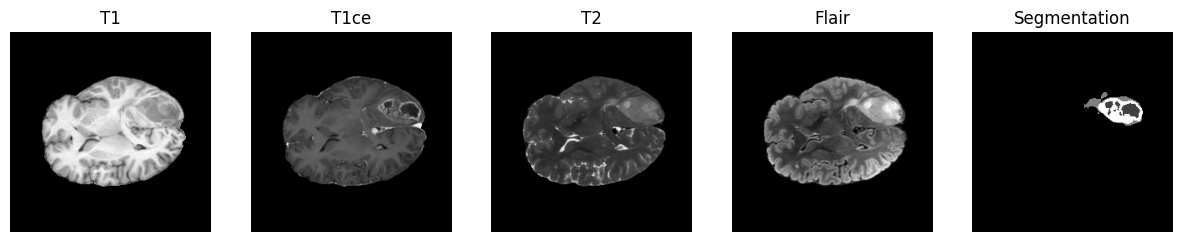

In [51]:
# Visualizing MRI slices
def plot_middle_slices(modalities, titles):
    fig, axes = plt.subplots(1, len(modalities), figsize=(15, 5))
    mid_slice = modalities[0].shape[2] // 2
    for i, (modality, title) in enumerate(zip(modalities, titles)):
        axes[i].imshow(modality[:, :, mid_slice], cmap='gray')
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.show()

plot_middle_slices([t1, t1ce, t2, flair, seg], ['T1', 'T1ce', 'T2', 'Flair', 'Segmentation'])

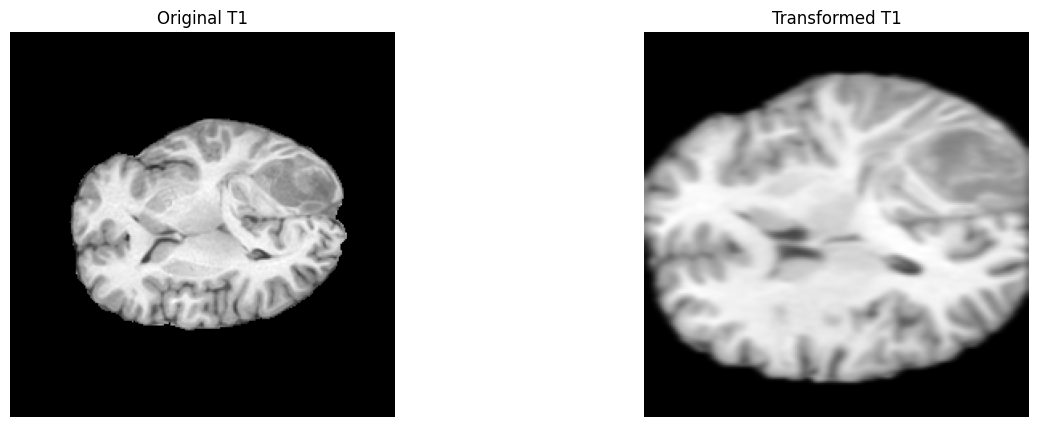

In [52]:
# Data Augmentation
transform = tio.Compose([
    tio.RandomFlip(axes=(0,), p=1),
    tio.RandomFlip(axes=(1,), p=0.5),
    tio.CropOrPad((160, 160, 100)),
    tio.Resample(0.75),
    tio.OneOf({tio.RandomElasticDeformation(): 0.6, tio.RandomAffine(): 0.4}),
    tio.RandomBlur(p=0.6),
    tio.RandomNoise(p=0.6)
])

def apply_transform(image):
    img_tensor = torch.tensor(image[np.newaxis, ...], dtype=torch.float32)
    return transform(img_tensor).numpy()[0]

transformed_t1 = apply_transform(t1)
plot_middle_slices([t1, transformed_t1], ['Original T1', 'Transformed T1'])

# Conclusion

In this notebook, we successfully:
✅ Loaded and preprocessed 3D MRI scans.
✅ Visualized different modalities.
✅ Applied augmentation for better generalization.
✅ Implemented a PyTorch DataLoader for efficient handling.
This is a foundation for all deep learning-based tumor segmentation. 🚀